# Slope Fitting - Exploring Methods 

This notebook serves as a demonstration of the possible ways to measure slope, demonstrated on an example PSD.

To actually use these metrics, implementations are available in slf/fit.py. This module uses a standardized API and offers and has a cleaner organization in ways that avoids the gymnastics used below to deal with array shape and log status.

In [33]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
from sklearn.linear_model import RANSACRegressor

In [2]:
# Import custom slope fitting code
from slf.plts.psd import plt_psd_1, plt_psd_2, plt_psd_shade
from slf.core.utils import exclude_psd

# Load FOOOF
from fooof import FOOOF
#from fooof.utils import trim_spectrum
from fooof.core.funcs import expo_nk_function as expf

### Example PSD

Load an example PSD, from eyes closed, resting state EEG data, extracted to the range of 3-40 Hz. 

In [3]:
# Load an example power spectrum to check fitting with
freqs = np.load('data/freqs.npy')
psd = np.load('data/psd.npy')

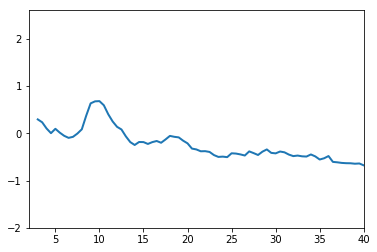

In [4]:
# Check a plot of the PSD
plt_psd_1(freqs, psd, False)

## Check FOOOF Fit of Data

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.5498, 0.6997                                          
                                                                                                  
                                       2 peaks were found:                                        
          

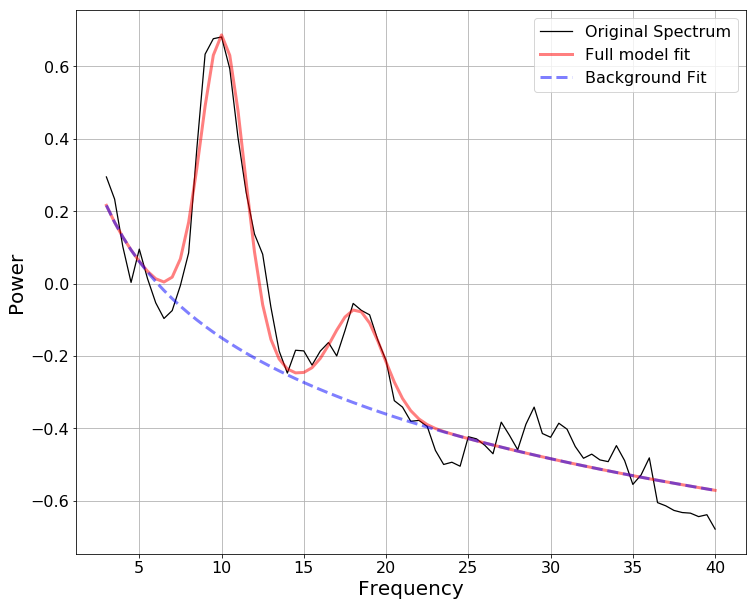

In [5]:
# Initialize FOOOF model
fm = FOOOF(peak_width_limits=[1, 8])

# Fit FOOOF
fm.report(freqs, psd, [3, 40])
sl_fooof = -fm.background_params_[1]

# Methods for Fitting PSD Slope

Words, words, words.

## Linear Fits (in log-log)

In [6]:
# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs))

### Simple Linear Fit

Fit with Ordinary Least Squares (OLS)

In [7]:
# Fit slope - simple linear fit
fit_ols = sm.OLS(np.log10(psd), fx).fit()
sl_ols = fit_ols.params[1]

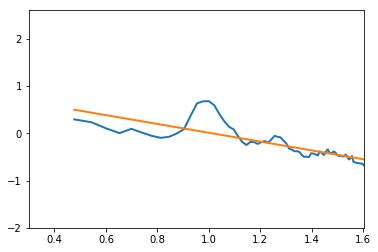

In [8]:
# Check the simple linear slope fit
plt_psd_2(freqs, psd, freqs, np.power(10, fit_ols.fittedvalues), log_f=True)

### Robust Slope Fitting with RLM

In [9]:
# Fit slope - robust linear fit to log-log PSD
fit_rlm = sm.RLM(np.log10(psd), fx).fit()
sl_rlm = fit_rlm.params[1]

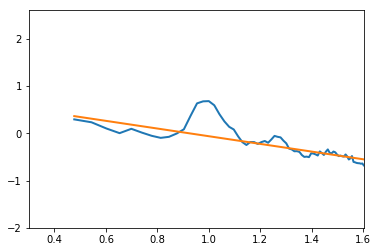

In [10]:
# Check the robust linear slope fit
plt_psd_2(freqs, psd, freqs, np.power(10, fit_rlm.fittedvalues), log_f=True)

### Robust Fitting with RANSAC

In [11]:
# Reshape freqs for RANSAC fit
freqs = freqs.reshape([len(freqs), 1])

In [12]:
# Initialize and fit with RANSAC
ransac_model = RANSACRegressor()
ransac_model.fit(np.log10(freqs), np.log10(psd))
sl_ran = ransac_model.estimator_.coef_[0]

/Users/tom/anaconda/envs/eeg36/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


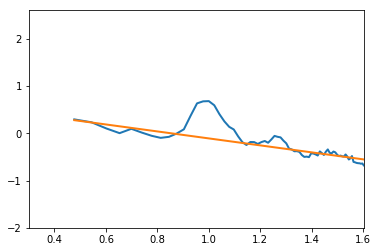

In [13]:
# Plot the slope fit, from RANSAC
plt_psd_2(freqs, psd, freqs, np.power(10, ransac_model.predict(np.log10(freqs))))

## Slope Fitting Excluding Alpha

In [14]:
# Exclude predefined alpha range
freqs_alph, psd_alph = exclude_psd(np.squeeze(freqs), psd, [7, 14])#, False)

# Reset freqs, with constant
fx = sm.add_constant(np.log10(freqs_alph))

### RLM Slope Fitting Excluding Generic Alpha Band

In [15]:
# Robust fit slope without alpha range
fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx).fit()
sl_rlm_alph = fit_rlm_alph.params[1]

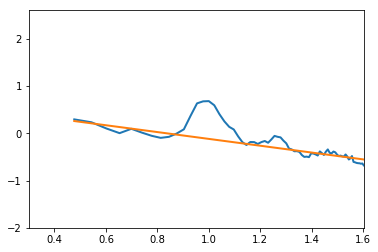

In [16]:
# Plot the slope fit, with alpha exclusion range (note plots original PSD with alpha included)
plt_psd_2(freqs, psd, freqs_alph, np.power(10, fit_rlm_alph.fittedvalues), log_f=True)

### RANSAC Slope Fitting Excluding Generic Alpha Band

In [17]:
# Fit alpha-exclusion with RANSAC
ransac_model_alph = RANSACRegressor()
ransac_model_alph.fit(np.log10(freqs_alph), np.log10(psd_alph))
sl_ran_alph = ransac_model_alph.estimator_.coef_[0][0]

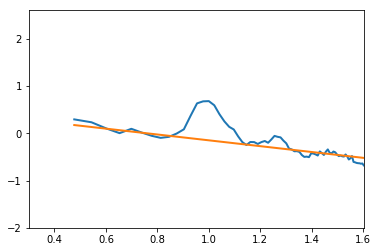

In [18]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs, psd, freqs_alph, np.power(10, ransac_model_alph.predict(np.log10(freqs_alph))))

## Slope Fitting Excluding Oscillations

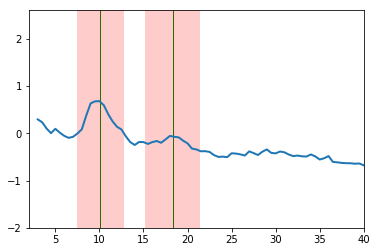

In [19]:
# Get oscillation definitions from FOOOF
cens = fm._gaussian_params[:, 0]
bws = fm._gaussian_params[:, 2]

# Plot PSD with oscillatory regions marked out
m = 2
plt_psd_shade(freqs, psd, cens, bws, m)

In [20]:
# Exclude FOOOF oscillation bands
psd_excl = psd
freqs_excl = np.squeeze(freqs)

for cen, bw in zip(cens, bws):
    freqs_excl, psd_excl = exclude_psd(freqs_excl, psd_excl, [cen-m*bw, cen+m*bw])

### RLM Slope Fitting Excluding Oscillatory Bands

In [21]:
# Robust fit slope without FOOF oscillation bands
fx = sm.add_constant(np.log10(freqs_excl))
fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx).fit()
sl_rlm_excl = fit_rlm_excl.params[1]

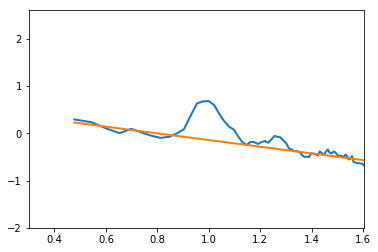

In [22]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs, psd, freqs_excl, np.power(10, fit_rlm_excl.fittedvalues), log_f=True)

### RANSAC Slope Fitting Excluding Oscillatory Bands

In [23]:
# Fit alpha-exclusion with RANSAC
ransac_model_excl = RANSACRegressor()
ransac_model_excl.fit(np.log10(freqs_excl), np.log10(psd_excl))
sl_ran_excl = ransac_model_excl.estimator_.coef_[0][0]

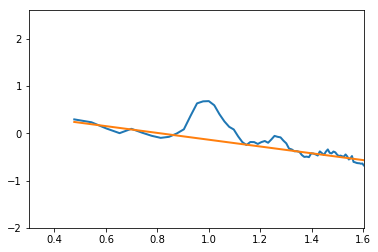

In [24]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs, psd, freqs_excl, np.power(10, ransac_model_excl.predict(np.log10(freqs_excl))))

## Exponential Fits

### Exponential Fit

In [25]:
# Fit exponential 1/f, with scipy curve_fit
fit_exp, _ = curve_fit(expf, np.squeeze(freqs), np.squeeze(np.log10(psd)), p0=[1, 1])
sl_exp = -fit_exp[1]

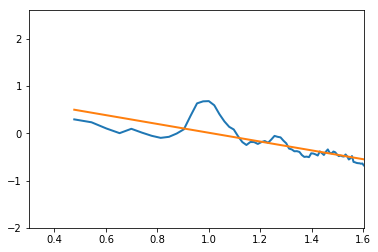

In [26]:
# Plot the slope fit, from exponential fit
plt_psd_2(freqs, psd, freqs, np.power(10, expf(freqs, *fit_exp)))

### Exponential Fit Excluding Alpha Region

In [27]:
# Fit exponential 1/f, with scipy curve_fit, excluding alpha range
fit_exp_alph, _ = curve_fit(expf, np.squeeze(freqs_alph), np.squeeze(np.log10(psd_alph)), p0=[1, 1])
sl_exp_alph = -fit_exp_alph[1]

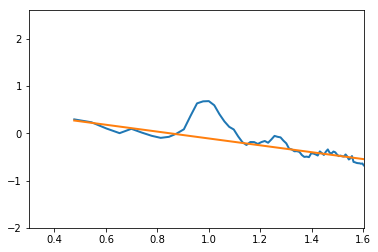

In [28]:
# Plot the slope fit, from alpha region excluded fit (note: plots original PSD with oscs included)
plt_psd_2(freqs, psd, freqs_alph, np.power(10, expf(freqs_alph, *fit_exp_alph)))

### Exponential Fit Excluding Oscillation Regions

In [29]:
# Fit exponential 1/f, with scipy curve_fit, excluding oscillatory regions
fit_exp_excl, _ = curve_fit(expf, np.squeeze(freqs_excl), np.squeeze(np.log10(psd_excl)), p0=[1, 1])
sl_exp_excl = -fit_exp_excl[1]

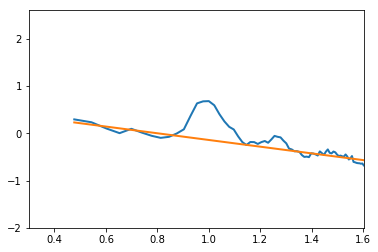

In [30]:
# Plot the slope fit, with osc excluded (note: plots original PSD with oscs included)
plt_psd_2(freqs, psd, freqs_excl, np.power(10, expf(freqs_excl, *fit_exp_excl)))

# Compare Slope Fits


In [31]:
# Print out results across all the different approaches
print('SLOPE FIT RESULTS \n')
print('OLS: \t\t\t', sl_ols)
print('RLM: \t\t\t', sl_rlm)
print('RLM-Exclude Alpha:\t', sl_rlm_alph)
print('RLM-Exclude Oscs:\t', sl_rlm_excl)
print('RANSAC:\t\t\t', sl_ran)
print('RANSAC-Exclude Alpha:\t', sl_ran_alph)
print('RANSAC-Exclude Oscs:\t', sl_ran_excl)
print('EXP: \t\t\t', sl_exp)
print('EXP-Exclude Alpha:\t', sl_exp_alph)
print('EXP-Exclude Oscs:\t', sl_exp_excl)
print('FOOOF:\t\t\t', sl_fooof)

SLOPE FIT RESULTS 

OLS: 			 -0.933060914185938
RLM: 			 -0.8133822433582695
RLM-Exclude Alpha:	 -0.7228972545346251
RLM-Exclude Oscs:	 -0.7087758083697184
RANSAC:			 -0.7386539362129703
RANSAC-Exclude Alpha:	 -0.6181749433212964
RANSAC-Exclude Oscs:	 -0.7191660939252857
EXP: 			 -0.9330609131352398
EXP-Exclude Alpha:	 -0.7264636284120363
EXP-Exclude Oscs:	 -0.7099949804395156
FOOOF:			 -0.6997273711191881


In [32]:
# Order slope fits by magnitude
all_sl_fits = [(sl_ols, 'OLS'), (sl_fooof, 'FOOOF'),
               (sl_rlm, 'RLM'), (sl_rlm_alph, 'RLM-EA'), (sl_rlm_excl, 'RLM-EO'),
               (sl_ran, 'RAN'), (sl_ran_alph, 'RAN-EA'), (sl_ran_excl, 'RAN-EO'),
               (sl_exp, 'EXP'), (sl_exp_alph, 'EXP-EA'), (sl_exp_excl, 'EXP-EO')]
all_sl_fits.sort()
all_sl_fits.reverse()

# Print out in order of slope fit magnitude
print('SLOPE FIT RESULTS (SORTED):')
for fit in all_sl_fits:
    print('\t {:1.5f} \t {}'.format(*fit))

SLOPE FIT RESULTS (SORTED):
	 -0.61817 	 RAN-EA
	 -0.69973 	 FOOOF
	 -0.70878 	 RLM-EO
	 -0.70999 	 EXP-EO
	 -0.71917 	 RAN-EO
	 -0.72290 	 RLM-EA
	 -0.72646 	 EXP-EA
	 -0.73865 	 RAN
	 -0.81338 	 RLM
	 -0.93306 	 EXP
	 -0.93306 	 OLS
